In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
import os
from collections import deque

In [10]:
timename = 'Time[hr]'
odname = 'OD600'
medianame = 'Media Used'
abname = 'Ciprofloxacin'
targetname = 'Target '+abname
estname = 'Estimated ' +abname
concname = 'Concentration [uM]'
conctypename = 'Concentration Type [uM]'

In [5]:
exp_name = '210126_morbidostat'
path = os.getcwd()
save_folder = 'morbidostat_analysis'
save_path = os.path.join(path,save_folder)
vial_nums = [0,3,5,6]
strain1 = 'MG1655'
strain2 = 'ZG-44.1'
strain3 = 'IAI40'
strain4 = 'NILS38'
vial_to_strain = {
           0: strain1,
           1: strain1,
           2: strain1,
           3: strain2,
           4: 0,
           5: strain2,
           6: strain2,
           7: strain3,
           8: strain3,
           9: strain3,
           10: strain4,
           11: strain4,
           12: strain4,
           13: 0,
           14: 0,
           15: 0
          }
volume = 25
switch_time = {strain1:0,strain2:0,strain3:0,strain4:0} # time when the media was switched to a higher concentration

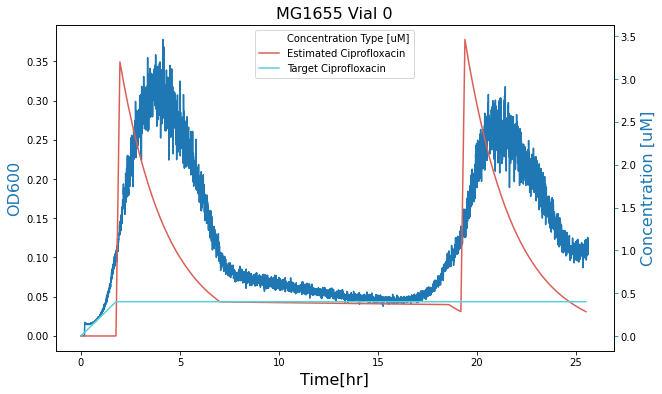

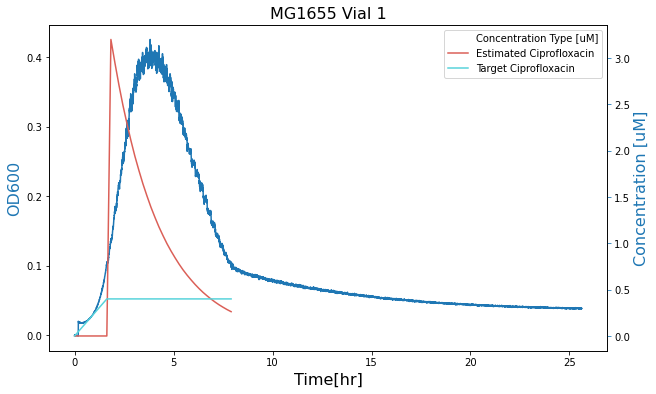

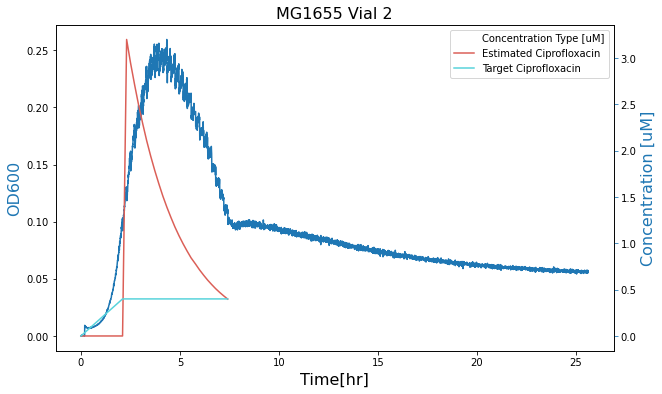

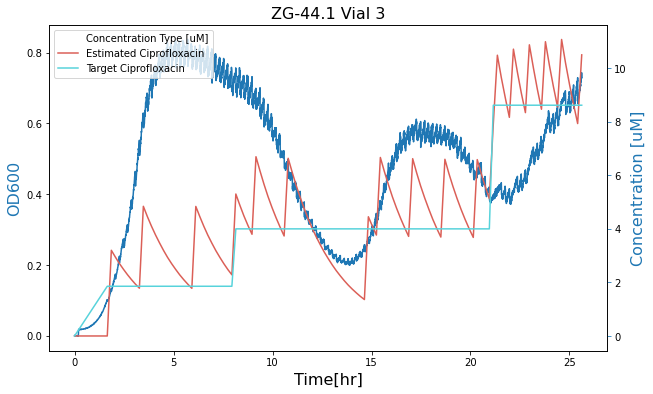

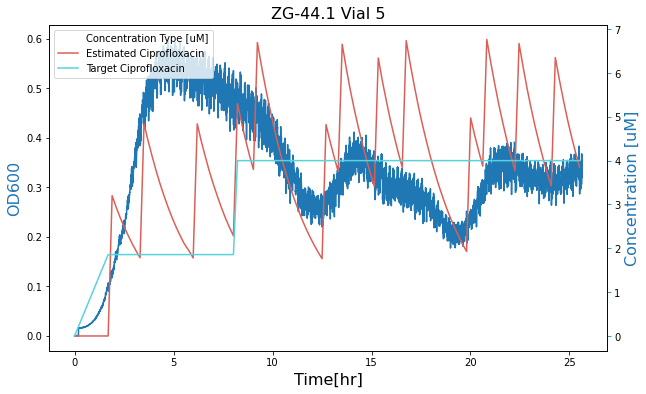

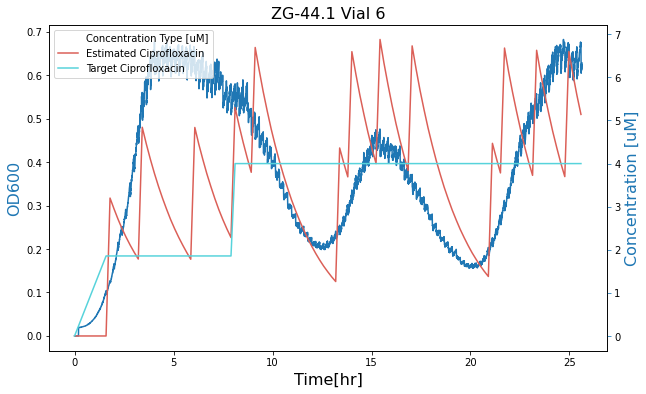

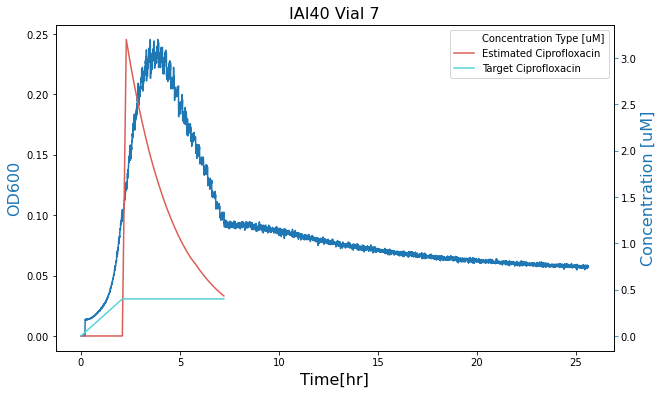

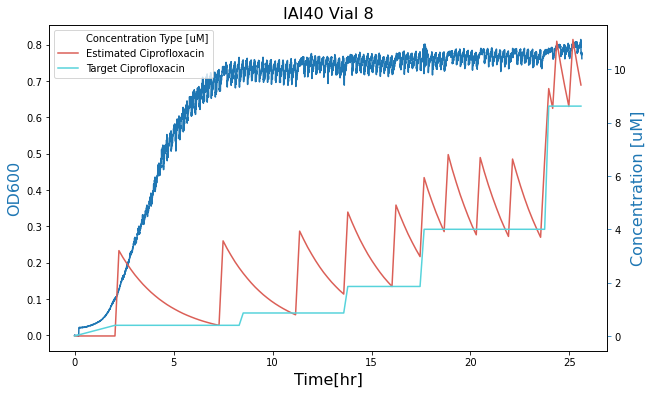

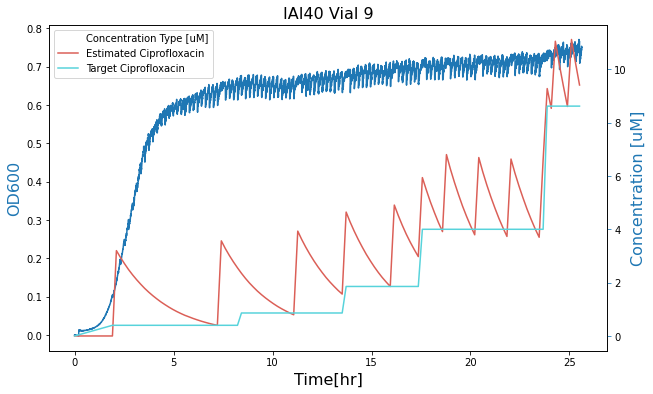

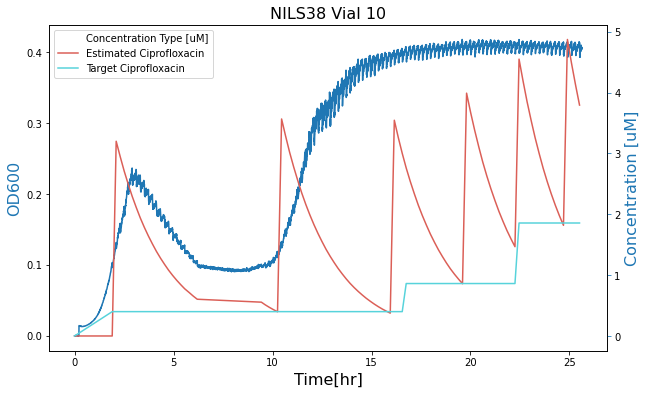

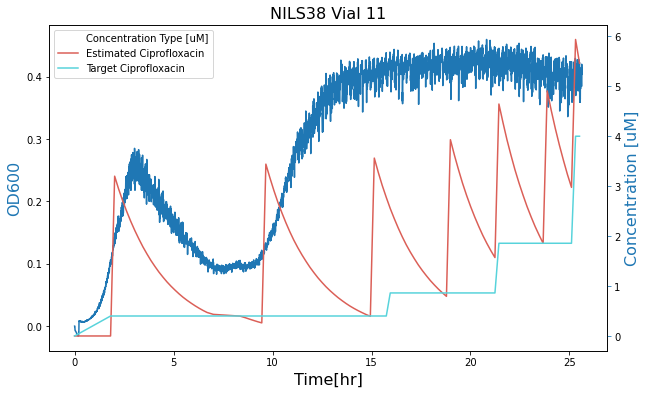

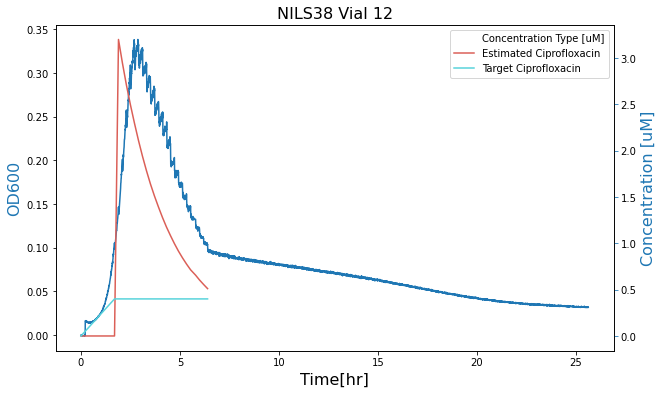

In [19]:
for x in vial_to_strain.keys():
    if vial_to_strain[x] == 0:
        continue
        
    od_path = "%s/%s/OD/vial%d_OD.txt" % (path, exp_name, x)
    od_data = np.genfromtxt(od_path, delimiter=',')
    odx = od_data[:, 0]
    ody = od_data[:, 1]
    od_last = np.median(ody[-7:])

    
    od_cycle_path = "%s/%s/cycle/vial%d_cycle.txt" % (path, exp_name,
                                                      x)
    with open(od_cycle_path, 'rb') as f:
        lines = deque(f, 30)
    od_cycle = np.genfromtxt(lines, delimiter=',')
    if len(od_cycle.shape) == 1:
        od_cycle = od_cycle.reshape(1, od_cycle.shape[0])
    last_od_cycle = od_cycle[-1, 0]

    morbido_path = "%s/%s/morbidostat/vial%d_morbidostat.txt" % (path,
                                                                 exp_name,
                                                                 x)
    mb_data = np.genfromtxt(morbido_path, delimiter=',')
    if len(mb_data.shape) == 1:
        mb_data = mb_data.reshape(1, mb_data.shape[0])
    current_conc = mb_data[-1, 3]
    current_moles = current_conc * volume
    od_df = pd.DataFrame(od_data,columns=[timename,odname])
    mb_df = pd.DataFrame(mb_data,columns=[timename,'X',medianame,estname,'Y',targetname])
    mb_df = mb_df.drop(columns=['X',medianame,'Y'])
    
    #trimming the dfs to where the media was switched out for plotting with better axes
    media_switch = switch_time[vial_to_strain[x]]
    switch = media_switch > 0
    if switch:
        trim_index = od_df[od_df[timename]==media_switch].index.values[0] # get the row number where media was switched
        od_df_trimmed = od_df[:trim_index]
        trim_index = mb_df[mb_df[timename]==media_switch].index.values[0] # get the row number where media was switched
        mb_df_trimmed = mb_df[:trim_index]
    
    #sns plots using long format
    mb_long = pd.melt(mb_df, id_vars=timename, var_name=conctypename, value_name=concname)
    
    #plotting the od and antibiotic conc on same graph
    fig, ax1 = plt.subplots(figsize=(10,6))
    color = 'tab:blue'
    if switch:
        ax1.set_title('FULL EXPERIMENT:: '+vial_to_strain[x]+' Vial '+str(x), fontsize=16)
    else:
        ax1.set_title(vial_to_strain[x]+' Vial '+str(x), fontsize=16)
    ax1.set_xlabel(timename, fontsize=16)
    ax1.set_ylabel(odname, fontsize=16, color=color)
    ax1 = sns.lineplot(x=timename, y=odname,data=od_df)
    ax1.tick_params(axis='y')
    ax2 = ax1.twinx()
    num_vars = 2
    palette = sns.color_palette("hls", num_vars)
    ax2.set_ylabel(estname, fontsize=16, color=color)
    ax2 = sns.lineplot(x=timename, y=concname,data=mb_long,hue=conctypename,palette=palette)
    
    ax2.tick_params(axis='y', color=color)
    plt.show()
    
    # plotting the trimmed dataframe to better see concentrations of antibiotic before switching medias
    if switch:
        mb_df = mb_df_trimmed
        od_df = od_df_trimmed
        mb_long = pd.melt(mb_df, id_vars=timename, var_name=conctypename, value_name=concname)
        fig, ax1 = plt.subplots(figsize=(10,6))
        color = 'tab:blue'
        ax1.set_title('BEFORE MEDIA SWITCH:: '+vial_to_strain[x]+' Vial '+str(x), fontsize=16)
        ax1.set_xlabel(timename, fontsize=16)
        ax1.set_ylabel(odname, fontsize=16, color=color)
        ax1 = sns.lineplot(x=timename, y=odname,data=od_df)
        ax1.tick_params(axis='y')
        ax2 = ax1.twinx()
        num_vars = 2
        palette = sns.color_palette("hls", num_vars)
        ax2.set_ylabel(estname, fontsize=16, color=color)
        ax2 = sns.lineplot(x=timename, y=concname,data=mb_long,hue=conctypename,palette=palette)

        ax2.tick_params(axis='y', color=color)
        plt.show()

In [15]:
def molarity_to_ugmL(uM,MW):
    '''takes in molarity in micromoles and turns into ug/mL'
    uM = micromolar ; MW = molecular weight (g/mol)'''
    M = uM * (10**-6) # umol/L * (10^-6mol/1umol) = mol/L
    gL = M * MW # mol/L * g/mol = g/L
    print('mg/1L media=',gL*1000,'(same as ug/mL)')

In [16]:
ab_molarity = 40 #concentration of the media in uM (umol/L)
ab_molweight = 331.346
molarity_to_ugmL(ab_molarity,ab_molweight)

mg/1L media= 13.253839999999999 (same as ug/mL)
